In [1]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Flatten
from keras.models import model_from_json
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# specify a number of output classes
# MNIST data has ten categories, each means particular digit
N_CLASSES  = 10

Using TensorFlow backend.


## Load and preprocess MNIST data

Data splitted in two sets - train and test

In [2]:
(X_train,y_train),(X_test,y_test) = mnist.load_data() 
 
print('Train size: {:5}'.format(len(X_train)))
print('Test size: {:6}'.format(len(X_test)))

Train size: 60000
Test size:  10000


Rescale original image data to be in range [0, 1]

In [3]:
# before rescaling
print('X_max before rescaling - {}'.format(X_train.max()))

X_train_rescaled = X_train / 255.
X_test_rescaled  = X_test / 255.
# after rescaling
print('X_max after rescaling  - {}'.format(X_train_rescaled.max()))

X_max before rescaling - 255
X_max after rescaling  - 1.0


Show one training example

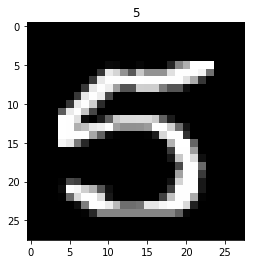

In [4]:
# randomly choose index of the image to show
i = np.random.randint(0, 9999)

plt.imshow(X_test_rescaled[i])
plt.title(y_test[i])
plt.gray()
plt.show()

Represent categorical labels as one-hot vectors

For example, imagine that we have ten classes of data samples. So for the label equals to 3 one-hot vector would be:
```python
    0 0 0 1 0 0 0 0 0 0 
```
This transformation is nessesary for computing categorical cross-entropy loss:
$$L = -\sum_{i}^N{L_i \log{(S_i)}},$$
Where $S$ is output from Softmax Layer and $L$ is Labels. 

In [8]:
y_train_categorical = to_categorical(y_train, num_classes=N_CLASSES)
y_test_categorical  = to_categorical(y_test, num_classes=N_CLASSES)

## Build neural networks models

We will construct three different types of NNs:
- shallow network with one hidden layer;
- deep convolutional neural network (CNN);
- recurrent neural network (RNN);

#### Shallow Network with one hidden layer

In [6]:
SimpleNN = Sequential() # keras class of sequential model allows us to build NN by adding new layers 

# for the first layer (our hidden layer) of sequential model we should specify inputshape
# ordinary NNs operates on 1D representations of data
# so the translation of each 28x28 image is vector size of 784
SimpleNN.add(Dense(1024,                   # number of output nodes
                   input_shape=(784,),     # for the first layer of sequential model we shouls specify the input shape
                   activation='sigmoid',   # activation function
                   kernel_initializer='random_uniform',  # weights initializer
                   bias_initializer='zeros'))            # bias initializer
SimpleNN.add(Dense(N_CLASSES, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros'))

# compiling model
SimpleNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print our model
SimpleNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### Deep Convolutional Network

In [7]:
ConvNN = Sequential()

# 32 means the number of filters, features
# (3,3) is tuple represents the filters sizes, e.g. each filter is a square with size 3x3
# padding='same' - we add zeros across each of edges of the input sample
# (28, 28, 1) - input shape, where 1 is a single gray channel (we may have RGB images with shape = 28,28,3)
ConvNN.add(Conv2D(32, (5,5), input_shape=(28, 28, 1), activation='relu'))
ConvNN.add(MaxPool2D(pool_size=(2,2)))
ConvNN.add(Conv2D(64, (5,5), padding='same', activation='relu'))
ConvNN.add(MaxPool2D(pool_size=(2,2)))
ConvNN.add(Flatten()) # operation that flattens input tensor
ConvNN.add(Dense(1024, activation='relu'))
ConvNN.add(Dense(N_CLASSES, activation='softmax'))

# compile model
ConvNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print model
ConvNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10250     
Total para

#### Recurrent Neural Network

In [8]:
RNN = Sequential()

# we extract 64 features from GRU neurons
# each image presented as 28 sequences, i.e., rows of pixels
RNN.add(GRU(64, input_shape=(28, 28)))
RNN.add(Dense(N_CLASSES, activation='softmax'))

# compile model
RNN.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# print model
RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                17856     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 18,506
Trainable params: 18,506
Non-trainable params: 0
_________________________________________________________________


## Train all three models

In [16]:
try:
    # rescale input data to pass to simpleNN
    X_train_rescaled = X_train_rescaled.reshape((len(X_train_rescaled), 28*28))
    X_test_rescaled  = X_test_rescaled.reshape((len(X_test_rescaled), 28*28))
    # fit shallow network
    print('Train Shallow Network')
    SimpleNN.fit(X_train_rescaled, y_train_categorical, epochs=3, validation_data=(X_test_rescaled, y_test_categorical))

    # rescale input data to pass to convNN
    X_train_rescaled = X_train_rescaled.reshape((len(X_train_rescaled), 28, 28, 1))
    X_test_rescaled  = X_test_rescaled.reshape((len(X_test_rescaled), 28, 28, 1))
    # fit convolutional network
    print('Train Convolutional Network')
    ConvNN.fit(X_train_rescaled, y_train_categorical, epochs=3, validation_data=(X_test_rescaled, y_test_categorical))

    # rescale input data to pass to RNN
    X_train_rescaled = X_train_rescaled.reshape((len(X_train_rescaled), 28, 28))
    X_test_rescaled  = X_test_rescaled.reshape((len(X_test_rescaled), 28, 28))
    # fit recurrent neural network
    print('Train Recurrent Neural')
    RNN.fit(X_train_rescaled, y_train_categorical, epochs=3, validation_data=(X_test_rescaled, y_test_categorical))
except KeyboardInterrupt:
    print('\nTraining was interrupted!')

Train Shallow Network
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 35s - loss: 0.0771 - acc: 0.9762 - val_loss: 0.0868 - val_acc: 0.9733
Epoch 2/3
15328/60000 [======>.......................] - ETA: 26s - loss: 0.0535 - acc: 0.9838
Training was interrupted!


### Restoring models

In [17]:
# shallow network with one hidden layer
# load model
with open('data/SimpleNN.json', 'r') as f:
    SimpleNN = model_from_json(f.read())
#load trainable weights
SimpleNN.load_weights('data/SimpleNN.h5')

# convolutional neural network
with open('data/ConvNN.json', 'r') as f:
    ConvNN = model_from_json(f.read())
ConvNN.load_weights('data/ConvNN.h5')

# recurrent neural network
with open('data/RNN.json', 'r') as f:
    RNN = model_from_json(f.read())
RNN.load_weights('data/RNN.h5')

### Compiling all three models
SimpleNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ConvNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Evaluate models

In [18]:
print('Test efficiencies')

#Shallow network
X_test_rescaled  = X_test_rescaled.reshape((len(X_test_rescaled), 28*28))
print('\tSimpleNN: {}'.format(SimpleNN.evaluate(X_test_rescaled, y_test_categorical)[1]))

#Convolutional Network
X_test_rescaled  = X_test_rescaled.reshape((len(X_test_rescaled), 28, 28, 1))
print('\tConvNN: {}'.format(ConvNN.evaluate(X_test_rescaled, y_test_categorical)[1]))

#Recurrent Network
X_test_rescaled  = X_test_rescaled.reshape((len(X_test_rescaled), 28, 28))
print('\tRNN: {}'.format(RNN.evaluate(X_test_rescaled, y_test_categorical)[1]))

Test efficiencies
 9984/10000 [============================>.] - ETA: 0s	RNN: 0.9834


### Saving models

In [ ]:
# shallow network with one hidden layer
with open('data/SimpleNN.json', 'w') as f:
    f.write(SimpleNN.to_json())        # save model's graph
SimpleNN.save_weights('data/SimpleNN.h5')   # save model's weights

# convolutional neural network
with open('data/ConvNN.json', 'w') as f:
    f.write(ConvNN.to_json())
ConvNN.save_weights('data/ConvNN.h5')

# recurrent neural network
with open('data/RNN.json', 'w') as f:
    f.write(RNN.to_json())
RNN.save_weights('data/RNN.h5')

## Github link - https://github.com/Kaliostrogoblin/NEC2017-neural-networks-workshop